In [1]:
#%autosave 0
from IPython.core.display import HTML, display
display(HTML("<style>.container { width:100% !important; }</style>"))

# Logistic Regression Using TensorFlow

I have adapted this example from an example of **Aymeric Damien**.  He has a lot of nice notebooks discussing TensorFlow at https://github.com/aymericdamien/TensorFlow-Examples/.

In [2]:
import gzip
import pickle
import random
import numpy             as np
import matplotlib.pyplot as plt

The function $\texttt{vectorized_result}(d)$ converts the digit $d \in \{0,\cdots,9\}$ and returns a NumPy vector $\mathbf{x}$ of shape $(10, 1)$ such that
$$
\mathbf{x}[i] = 
\left\{
  \begin{array}{ll}
     1 & \mbox{if $i = j$;} \\
     0 & \mbox{otherwise.}
  \end{array}  
\right.
$$
This function is used to convert a digit $d$ into the expected output of a neural network that has an output unit for every digit.

In [3]:
def vectorized_result(d):
    e    = np.zeros((10, ), dtype=np.float32)
    e[d] = 1.0
    return e

The data that we are using is stored as a <a href="https://docs.python.org/3/library/gzip.html">gzipped</a>, 
<a href="https://docs.python.org/3/library/pickle.html">pickled</a> file.  

The function $\texttt{load_data}()$ returns a pair of the form
$$ (\texttt{training_data}, \texttt{test_data}) $$
where 
<ul>
<li> $\texttt{training_data}$ is a list containing 60,000 pairs $(\textbf{x}, \textbf{y})$ s.t. $\textbf{x}$ is a 784-dimensional `numpy.ndarray` containing the input image and $\textbf{y}$ is a 10-dimensional `numpy.ndarray` corresponding to the correct digit for x.</li>
<li> $\texttt{test_data}$ is a list containing 10,000 pairs $(\textbf{x}, y)$.  In each case, 
     $\textbf{x}$ is a 784-dimensional `numpy.ndarry` containing the input image, 
     and $y$ is the corresponding digit value.
</ul>
Note that the formats for training data and test data are different.

In [4]:
def load_data():
    with gzip.open('mnist.pkl.gz', 'rb') as f:
        train, validate, test = pickle.load(f, encoding="latin1")
    X_train = np.array([np.reshape(x, (784, )) for x in train[0]])
    X_test  = np.array([np.reshape(x, (784, )) for x in test [0]])
    Y_train = np.array([vectorized_result(y) for y in train[1]])
    Y_test  = np.array([vectorized_result(y) for y in test [1]])
    return (X_train, X_test, Y_train, Y_test)

In [5]:
X_train, X_test, Y_train, Y_test = load_data()
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((50000, 784), (10000, 784), (50000, 10), (10000, 10))

The function $\texttt{show_digit}(\texttt{row}, \texttt{columns}, \texttt{offset})$ 
shows $\texttt{row} \cdot \texttt{columns}$ images of the training data.  The first image shown is the image at index $\texttt{offset}$.

In [6]:
def show_digits(rows, columns, offset=0):
    f, axarr = plt.subplots(rows, columns)
    for r in range(rows):
        for c in range(columns):
            i     = r * columns + c + offset
            image = 1 - X_train[i,:]
            image = np.reshape(image, (28, 28))
            axarr[r, c].imshow(image, cmap="gray")
            axarr[r, c].axis('off')
    plt.savefig("digits.pdf")    
    plt.show()

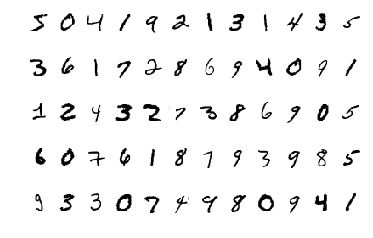

In [8]:
show_digits(5, 12)

Create placeholders to use for the data.  Below, `None` stands for the yet unknown number of training examples.

In [9]:
import tensorflow as tf

In [10]:
%env KMP_DUPLICATE_LIB_OK=TRUE

env: KMP_DUPLICATE_LIB_OK=TRUE


In [11]:
X = tf.placeholder(tf.float32, [None, 784]) # mnist data image of shape 28*28=784
Y = tf.placeholder(tf.float32, [None,  10]) # 0-9 digits recognition => 10 classes

The variable `W` is the <em style="color:blue;">weight matrix</em>, while `b` is the <em style="color:blue;">bias vector</em>.

In [13]:
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

We construct model the model for logistic regression. `Y_pred` is the prediction vector.  We use the 
<em style="color:blue;">softmax activation function</em>.  For a $d$-dimensional vector $\mathbf{z}$, this function is defined as
$$ \sigma(\mathbf{z})_i := \frac{\exp(z_i)}{\;\displaystyle\sum\limits_{j=1}^d \exp(z_j)\;} $$
This function is predifined in TensorFlow.
Here, the vector $\mathbf{z}$ is defined as
$$ \mathbf{z} = \mathbf{x} \cdot W + \mathbf{b} $$

In [14]:
Y_pred = tf.nn.softmax(tf.matmul(X, W) + b) 

We use the <em style="color:blue;">cross entropy</em> as a cost function. This is defined as
$$ -\sum\limits_{i=1}^d \mathtt{Y}_i \cdot \ln(\mathtt{Y\_pred}_i) $$
Here, $\mathtt{Y}_i$ is the expected outcome, while $\mathtt{Y\_pred}_i$ is the output predicted by our model.

In [15]:
cost = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(Y_pred), reduction_indices=1))

Set some hyperparameters.

In [16]:
learning_rate   = 0.01
training_epochs = 30
batch_size      = 100
num_examples    = X_train.shape[0]

We use <em style="color:blue;">gradient descent</em> to minimize this cost function.

In [17]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

The function $\texttt{next_batch}(s)$ returns the next batch of the given size.  It returns a pair of the form $(X, Y)$ where $X$ is a matrix of shape
$(s, 784)$ and $Y$ is a matrix of shape $(s, 10)$.

In [18]:
def next_batch(size):
    global count
    X_batch  = X_train[count:count+size,:]
    Y_batch  = Y_train[count:count+size,:]
    count   += size
    return X_batch, Y_batch

In [19]:
init = tf.global_variables_initializer()
with tf.Session() as tfs:
    tfs.run(init)
    for epoch in range(training_epochs):
        count    = 0
        avg_cost = 0.0
        num_batches = int(num_examples / batch_size)
        # Loop over all batches
        for i in range(num_batches):
            X_batch, Y_batch = next_batch(batch_size)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = tfs.run([optimizer, cost], {X: X_batch, Y: Y_batch})
            # Compute average loss
            avg_cost += c / num_batches
        print("Epoch:", '%2d,' % epoch, "cost =", "{:.9f}".format(avg_cost))
    print("Optimization Finished!")
    # Test model
    correct = tfs.run(tf.equal(tf.argmax(Y_pred, 1), tf.argmax(Y, 1)), {X: X_test, Y: Y_test})

print("Accuracy:", np.sum(correct) / len(correct))

Epoch:  0, cost = 1.231531356
Epoch:  1, cost = 0.697868880
Epoch:  2, cost = 0.576801274
Epoch:  3, cost = 0.518285587
Epoch:  4, cost = 0.482442577
Epoch:  5, cost = 0.457686247
Epoch:  6, cost = 0.439288881
Epoch:  7, cost = 0.424925673
Epoch:  8, cost = 0.413306787
Epoch:  9, cost = 0.403653085
Epoch: 10, cost = 0.395463047
Epoch: 11, cost = 0.388397628
Epoch: 12, cost = 0.382218410
Epoch: 13, cost = 0.376752250
Epoch: 14, cost = 0.371870014
Epoch: 15, cost = 0.367473164
Epoch: 16, cost = 0.363485055
Epoch: 17, cost = 0.359845043
Epoch: 18, cost = 0.356504429
Epoch: 19, cost = 0.353423597
Epoch: 20, cost = 0.350569953
Epoch: 21, cost = 0.347916379
Epoch: 22, cost = 0.345440124
Epoch: 23, cost = 0.343121917
Epoch: 24, cost = 0.340945327
Epoch: 25, cost = 0.338896237
Epoch: 26, cost = 0.336962434
Epoch: 27, cost = 0.335133313
Epoch: 28, cost = 0.333399583
Epoch: 29, cost = 0.331753076
Optimization Finished!
Accuracy: 0.9139
